In [1]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt
import json
from scipy.spatial.transform import Rotation as R


* Load image and calibration data. 
* Convert to rgb to gray
* Create a cyl class to convert  from image to world
* Create a fisheye class from world to image.
*  Transform the image. No runtime constraints.


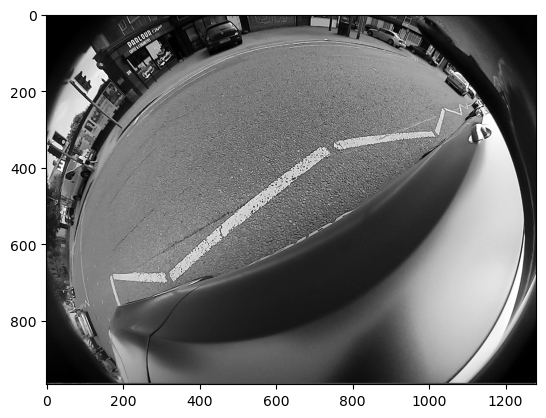

In [2]:
# load image 
rgb_img = cv2.imread('input/00000_MVR.png',cv2.IMREAD_COLOR)
in_img = cv2.cvtColor(rgb_img,cv2.COLOR_BGR2GRAY)
plt.imshow(in_img,cmap='gray')

In [72]:
class Fisheye(object):
    def __init__(self,quat,intrins):
        self.quat= quat
        self.intrins = intrins
    def world_image(self,world_cord):
        cam_cord =self.world_camera(world_cord)
        imag_cord = self.camera_image(cam_cord)
        return imag_cord
    def world_camera(self,world_cord):
        r = R.from_quat(quat)
        cam_cord = np.matmul(r.as_matrix(),world_cord)
        #print(type(cam_cord))
        return cam_cord
    def get_rho(self,theta):
        val = self.intrins['k1']* theta+ self.intrins['k2'] * theta**2 + self.intrins['k3'] * theta**3 + self.intrins['k4']* theta**4
        return val
    def camera_image(self,cam_cord):
        cam_x= cam_cord.item(0)
        cam_y= cam_cord.item(1)
        cam_z = cam_cord.item(2)
        chi = np.sqrt(cam_x**2 + cam_y**2) 
        theta = np.arctan2(chi,cam_z)
        rho = self.get_rho(theta)
        u_d =0
        v_d =0
        if chi !=0 :
            u_d = rho*cam_x/chi
            v_d = rho*cam_y/chi
        u= u_d+ self.intrins['cx_offset'] + (self.intrins['width']/2) -0.5
        v = v_d+ self.intrins['cy_offset'] + (self.intrins['height']/2) -0.5
        return (u,v)
        

In [107]:
class CylindricalCamera(object):
    def __init__(self,angles,intrins):
        self.angles = angles
        self.intrins= intrins
    def image_world(self,ix,iy):
        cam_cord= self.image_camera(ix,iy)
        world_cord = self.camera_world(cam_cord)
        return world_cord
    def image_camera(self,ix,iy):
        theta = (ix-self.intrins[2])/(self.intrins[0])
        h = (iy-self.intrins[3])/(self.intrins[1])
        cam_x = np.cos(theta)
        cam_y = np.sin(theta)
        cam_z = h
        return np.array([[cam_x],[cam_y],[cam_z]])
    def camera_world(self,cam_cord):
        r= R.from_euler('zyx',self.angles)
        w= np.matmul(np.transpose(r.as_matrix()),cam_cord)
        return w
    

In [108]:
# Load calibration data
f = open('/home/sravya/Documents/Code/Data/calibration(test)/00000_MVR.json')
data = json.load(f)
quat = data['extrinsic']['quaternion']
intrins = data['intrinsic']

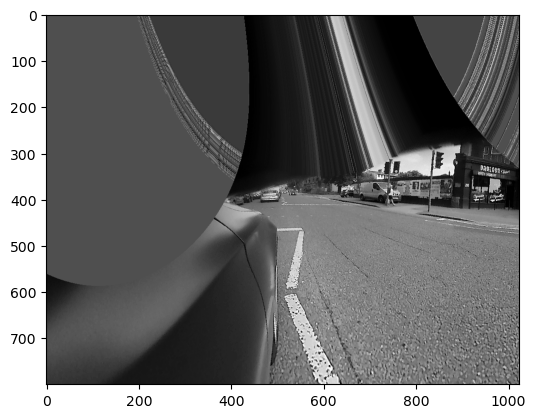

In [109]:
# create cyl image 

cyl_image = np.zeros((800,1024),dtype=np.uint8)
fisheye_cam = Fisheye(quat,intrins)
cyl_intrins = [350,350,512,400]
#cyl_angles = [0.0, 0.0, -np.pi/2]
cyl_angles = [-3.14159265,  3.14159265, -0.        ]
#cyl_angles = [0.0,np.pi/2, 0.0]
cylindrical_cam = CylindricalCamera(cyl_angles,cyl_intrins)

for r in range(0,800):
    for c in range(0,1024):
        world_cord = cylindrical_cam.image_world(c,r)
        imag_cord =fisheye_cam.world_image(world_cord)
        # fx = int(imag_cord.item(0))
        # fy = int(imag_cord.item(1))
        ix = max(0, min(int(imag_cord[0]),1279))
        iy = max(0,min(int(imag_cord[1]),965))
        cyl_image[r,c]=in_img[iy,ix]
        
plt.imshow(cyl_image,cmap='gray')

In [97]:
rotation = R.from_quat(quat).as_matrix()
rot = R.from_matrix(rotation).as_euler('zxz')
rot = np.round(rot/ (np.pi / 2)) * (np.pi / 2)
rot

array([-3.14159265,  3.14159265, -0.        ])

In [76]:
rot_mat = np.array([[0,1,0],[0,0,-1],[1,0,0]])
euler_angles = R.from_matrix(rot_mat).as_euler('zyx')
euler_angles

/tmp/ipykernel_143945/2517250603.py:2: UserWarning: Gimbal lock detected. Setting third angle to zero since it is not possible to uniquely determine all angles.
  euler_angles = R.from_matrix(rot_mat).as_euler('zyx')


array([ 1.57079633,  1.57079633, -0.        ])

In [8]:
intrins

{'aspect_ratio': 1.0,
 'cx_offset': 3.468,
 'cy_offset': -1.705,
 'height': 966.0,
 'k1': 337.657,
 'k2': -16.126,
 'k3': 27.487,
 'k4': 0.888,
 'model': 'radial_poly',
 'poly_order': 4,
 'width': 1280.0}

In [94]:
x = (R.from_euler ('zyx',[ 1.57079633,  1.57079633, -0.])).as_matrix()
y = (R.from_euler('zyx', [0,0,-np.pi/2])).as_matrix()
z =np.matmul(y,x)
angles = R.from_matrix(z).as_euler('zyx')
angles

/tmp/ipykernel_143945/2061909588.py:4: UserWarning: Gimbal lock detected. Setting third angle to zero since it is not possible to uniquely determine all angles.
  angles = R.from_matrix(z).as_euler('zyx')


array([ 3.20510357e-09,  1.57079632e+00, -0.00000000e+00])